  Preparing metadata (setup.py) ... done
📊 Récupération de BTC-USD...
📊 Récupération de ETH-USD...
📊 Récupération de AAPL...
📊 Récupération de TSLA...
📊 Récupération de SOL-USD...
✅ Dataset prêt pour la prédiction à J+1 (avec RSI) !
🚀 Modèle Random Forest entraîné avec succès !


/tmp/ipython-input-1292414598.py:137: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances, y=feature_importances.index, palette="viridis")


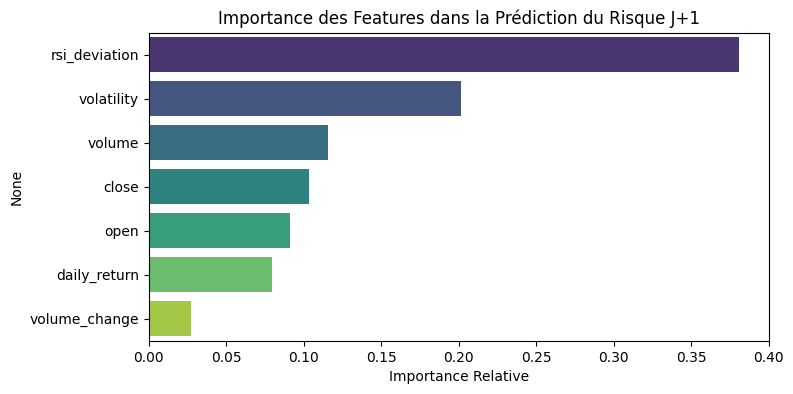


--- Importance des Features ---
 rsi_deviation    0.381107
volatility       0.201412
volume           0.115979
close            0.103500
open             0.091378
daily_return     0.079609
volume_change    0.027015
dtype: float64

--- PERFORMANCE SUR L'ENSEMBLE DE TEST (Prédiction J+1) ---
              precision    recall  f1-score   support

        High       0.79      0.62      0.69        84
         Low       0.64      0.83      0.72        82
      Medium       0.59      0.54      0.56        82

    accuracy                           0.66       248
   macro avg       0.67      0.66      0.66       248
weighted avg       0.67      0.66      0.66       248

Accuracy Test (J+1): 66.13%


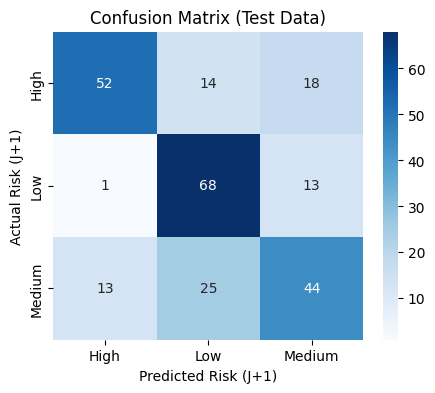


🛡️ Application du Feature Squeezing pour la robustesse cyber...

-------------------------------------------
📈 Predicted Risk for 10 New Assets (Risk J+1)
-------------------------------------------
 Volatility (%)  Volume Change (%)  RSI Deviation Predicted_Future_Risk
       3.913220           0.000000      28.953735                   Low
       2.907979         115.946067      29.152182                Medium
       3.146718          12.926493       9.205907                Medium
       3.916231          58.413432      20.277738                Medium
       2.803025          46.875889       6.459042                Medium
       4.786238         108.400820      40.616463                Medium
       3.116831          96.732939      44.236834                Medium
       3.280590        1989.834699       7.397680                Medium
       3.162247         209.632185      40.621838                Medium
       2.259263          97.262326      28.076060                Medium

Pipelin

In [1]:
# ============================================
# Risk Prediction ML Pipeline - AVEC CYBERSÉCURITÉ (Feature Squeezing)
# ============================================

# Installation des packages nécessaires
!pip install yfinance pandas scikit-learn matplotlib seaborn ta scipy -q # Ajout de scipy

# -----------------------------
# 1️⃣ Import des librairies
# -----------------------------
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import ta.momentum as ta_momentum
from scipy.ndimage import median_filter # 💡 Import pour Feature Squeezing

# -----------------------------
# 2️⃣ Générer le dataset (Calcul des Features)
# -----------------------------
symbols = ['BTC-USD', 'ETH-USD', 'AAPL', 'TSLA', 'SOL-USD']
lookback_days = 300
all_hist = []

# Coefficients de pondération pour la création du label de risque
WEIGHT_VOL = 0.4
WEIGHT_RETURN = 0.2
WEIGHT_VOLUME_CHANGE = 0.2
WEIGHT_RSI_ABS = 0.2

# Définition de l'objet de normalisation global
GLOBAL_SCALER = MinMaxScaler()

for symbol in symbols:
    print(f"📊 Récupération de {symbol}...")
    ticker = yf.Ticker(symbol)
    end_date = datetime.now()
    start_date = end_date - timedelta(days=lookback_days)

    hist = ticker.history(start=start_date, end=end_date, interval='1d')
    if hist.empty:
        print(f"⚠️ Pas de données pour {symbol}")
        continue

    # --- CALCUL DES FEATURES D'ENTRÉE ---
    hist['symbol'] = symbol.replace('-USD','')
    hist['volatility'] = (hist['High'] - hist['Low']) / hist['Open']
    hist['daily_return'] = hist['Close'].pct_change().abs()
    hist['volume_change'] = hist['Volume'].pct_change().abs().fillna(0)

    # Feature Améliorée: RSI
    hist['rsi'] = ta_momentum.RSIIndicator(close=hist['Close'], window=14).rsi()
    hist['rsi_deviation'] = np.abs(hist['rsi'] - 50)

    hist.dropna(inplace=True)

    # Préparation du DataFrame final
    hist = hist[['symbol', 'Open', 'Close', 'Volume', 'volatility', 'daily_return', 'volume_change', 'rsi_deviation']]
    hist.rename(columns={'Open': 'open', 'Close': 'close', 'Volume': 'volume'}, inplace=True)

    all_hist.append(hist)

df = pd.concat(all_hist).reset_index(drop=True)
df.dropna(inplace=True)

# -----------------------------
# 3️⃣ Préparation des labels et décalage (J+1) - CODE CORRIGÉ
# -----------------------------

# 1. NORMALISATION GLOBALE
feature_cols_norm = ['volatility', 'daily_return', 'volume_change', 'rsi_deviation']
df[[f'{col}_norm' for col in feature_cols_norm]] = GLOBAL_SCALER.fit_transform(df[feature_cols_norm])

# 2. CALCUL DU SCORE DE RISQUE GLOBAL (J) - CORRECTION DE LA KEYERROR
df['advanced_risk_score'] = (
    WEIGHT_VOL * df['volatility_norm'] +
    WEIGHT_RETURN * df['daily_return_norm'] +
    WEIGHT_VOLUME_CHANGE * df['volume_change_norm'] +
    WEIGHT_RSI_ABS * df['rsi_deviation_norm']
)

# 3. Assignation du risque (quantiles)
risk_thresholds = df['advanced_risk_score'].quantile([0.33, 0.66]).tolist()

def assign_advanced_risk(score):
    if score <= risk_thresholds[0]:
        return 'Low'
    elif score <= risk_thresholds[1]:
        return 'Medium'
    else:
        return 'High'

df['risk'] = df['advanced_risk_score'].apply(assign_advanced_risk)

# 4. DÉCALAGE DU LABEL POUR LA PRÉDICTION À J+1
df['future_risk'] = df.groupby('symbol')['risk'].shift(-1)

# Nettoyage
df.drop(columns=[col for col in df.columns if 'norm' in col or 'score' in col or col == 'risk'], inplace=True)
df.dropna(subset=['future_risk'], inplace=True)

print("✅ Dataset prêt pour la prédiction à J+1 (avec RSI) !")

# Définition des features (X) et du label futur (y)
X = df.drop(columns=['symbol', 'future_risk'])
y = df['future_risk']

# Encodage des labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded,shuffle=True
)

# -----------------------------
# 4️⃣ Définir et entraîner le modèle (Analyse des Features)
# -----------------------------
model = RandomForestClassifier(
    n_estimators=150, max_depth=4, min_samples_leaf=5,
    random_state=42, class_weight='balanced'
)
model.fit(X_train, y_train)
print("🚀 Modèle Random Forest entraîné avec succès !")

# Affichage de l'Importance des Features pour la transparence du modèle
feature_importances = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False)

plt.figure(figsize=(8, 4))
sns.barplot(x=feature_importances, y=feature_importances.index, palette="viridis")
plt.title("Importance des Features dans la Prédiction du Risque J+1")
plt.xlabel("Importance Relative")
plt.show()

print("\n--- Importance des Features ---\n", feature_importances)

# -----------------------------
# 5️⃣ Évaluation du modèle
# -----------------------------
y_pred_test = model.predict(X_test)

print("\n--- PERFORMANCE SUR L'ENSEMBLE DE TEST (Prédiction J+1) ---")
print(classification_report(y_test, y_pred_test, target_names=le.classes_))

acc_test = accuracy_score(y_test, y_pred_test)
print(f"Accuracy Test (J+1): {acc_test*100:.2f}%")

# Matrice de Confusion
cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
             xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted Risk (J+1)")
plt.ylabel("Actual Risk (J+1)")
plt.title("Confusion Matrix (Test Data)")
plt.show()

# -----------------------------
# 🔒 Fonction de Défense Cyber : Feature Squeezing
# -----------------------------

def feature_squeeze(X_input_df, quantization_levels=256, window_size=3):
    """
    Applique la Quantification (réduction de précision) et le Filtre Médian
    pour éliminer les perturbations adversariales subtiles sur les features.
    Les colonnes de prix/volume bruts ne sont pas affectées.
    """
    X_squeezed = X_input_df.copy()

    features_to_squeeze = ['volatility', 'daily_return', 'volume_change', 'rsi_deviation']

    # 1. Quantification des Couleurs (réduction de la précision)
    for col in features_to_squeeze:
        if col in X_squeezed.columns:
            # Assure que les valeurs sont traitées comme étant entre 0 et 1 (normalisées)
            X_squeezed[col] = np.round(X_squeezed[col] * (quantization_levels - 1)) / (quantization_levels - 1)

    # 2. Lissage Spatial (Median Filtering)
    for col in features_to_squeeze:
        if col in X_squeezed.columns:
            # Application du filtre médian sur la série temporelle
            # Note: Ici, nous traitons le batch de test synthétique comme une série
            X_squeezed[col] = median_filter(X_squeezed[col], size=window_size, mode='reflect')

    return X_squeezed


# -----------------------------
# 6️⃣ Prédiction pour de Nouveaux Assets (Test Synthétique SÉCURISÉ)
# -----------------------------
N_NEW_ASSETS = 10
np.random.seed(100)

# Génération réaliste des prix (Volatilité Max ~ 5% pour éviter les Highs extrêmes)
open_samples = np.random.uniform(10, 50000, N_NEW_ASSETS)
close_samples = open_samples * np.random.uniform(0.95, 1.05, N_NEW_ASSETS)
volume_samples = np.random.uniform(10000, 1500000, N_NEW_ASSETS)

X_pred = pd.DataFrame({
    'open': open_samples,
    'close': close_samples,
    'volume': volume_samples
})

# Calcul des features secondaires
X_pred['volatility'] = (np.abs(X_pred['open'] - X_pred['close'])) / X_pred['open']
X_pred['daily_return'] = np.abs(X_pred['close'].pct_change().fillna(0))
X_pred['volume_change'] = np.abs(X_pred['volume'].pct_change().fillna(0))
# Simulation de la déviation du RSI (valeurs entre 5 et 45, typique)
X_pred['rsi_deviation'] = np.random.uniform(5, 45, N_NEW_ASSETS)


# --- ÉTAPE CYBER 1 : NORMALISATION DES NOUVELLES DONNÉES ---
# Seules les 4 features sont normalisées.
X_features = X_pred[['volatility', 'daily_return', 'volume_change', 'rsi_deviation']]
X_features_norm = pd.DataFrame(
    GLOBAL_SCALER.transform(X_features),
    columns=X_features.columns
)
# Recombinez les données brutes (prix/volume) avec les features normalisées.
X_pred_norm = X_pred[['open', 'close', 'volume']].reset_index(drop=True)
X_pred_norm[X_features_norm.columns] = X_features_norm


# --- ÉTAPE CYBER 2 : FEATURE SQUEEZING (DÉFENSE) ---
print("\n🛡️ Application du Feature Squeezing pour la robustesse cyber...")
X_pred_squeezed = feature_squeeze(X_pred_norm.copy())

# Assurez l'ordre des colonnes avant la prédiction (seulement les 7 colonnes)
X_pred_final = X_pred_squeezed[X_train.columns]


# --- PRÉDICTION SÉCURISÉE ---
risk_pred_encoded = model.predict(X_pred_final) # Utilise les données SQUEEZED
risk_labels = le.inverse_transform(risk_pred_encoded)

print("\n-------------------------------------------")
print(f"📈 Predicted Risk for {N_NEW_ASSETS} New Assets (Risk J+1)")
print("-------------------------------------------")

# Pour l'affichage, nous utilisons les valeurs des features NORMALISÉES (avant squeeze)
results_df = X_pred_norm.copy()
results_df['Predicted_Future_Risk'] = risk_labels
results_df['Volatility (%)'] = results_df['volatility'] * 100
results_df['Volume Change (%)'] = results_df['volume_change'] * 100
results_df['RSI Deviation'] = results_df['rsi_deviation'] # C'est la valeur normalisée ici, mais on l'affiche ainsi

# Pour plus de clarté, affichons les features non normalisées utilisées au départ
X_pred['Volatility (%)'] = (np.abs(X_pred['open'] - X_pred['close'])) / X_pred['open'] * 100
X_pred['Volume Change (%)'] = np.abs(X_pred['volume'].pct_change().fillna(0)) * 100
X_pred['RSI Deviation'] = X_pred['rsi_deviation']

print(X_pred[['Volatility (%)', 'Volume Change (%)', 'RSI Deviation']].reset_index(drop=True).join(results_df['Predicted_Future_Risk']).to_string(index=False))

# -----------------------------
# ✅ FIN
# -----------------------------
print("\nPipeline corrigé, entraînement et prédiction sécurisée terminés.")

In [2]:
import joblib
import os
from datetime import datetime

# --- Définition du chemin de sauvegarde ---
# Créez un dossier "ML_Models" sur votre Drive si ce n'est pas déjà fait.
DRIVE_PATH = '/content/model'

# Assurez-vous que le répertoire existe
if not os.path.exists(DRIVE_PATH):
    os.makedirs(DRIVE_PATH)
    print(f"Dossier créé: {DRIVE_PATH}")

# Nom du fichier avec horodatage pour éviter les conflits
timestamp = datetime.now().strftime("%Y%m%d_%H%M")
MODEL_FILENAME = f'RandomForest_Risk_J+1_{timestamp}.joblib'
SAVE_PATH = os.path.join(DRIVE_PATH, MODEL_FILENAME)


# --- Sauvegarde du modèle (avec joblib) ---
# Votre modèle s'appelle 'model' dans les étapes précédentes.
try:
    joblib.dump(model, SAVE_PATH)
    print(f"\n✅ Modèle enregistré avec succès sur Google Drive à :")
    print(f"-> {SAVE_PATH}")
except Exception as e:
    print(f"\n❌ Erreur lors de la sauvegarde du modèle: {e}")


✅ Modèle enregistré avec succès sur Google Drive à :
-> /content/model/RandomForest_Risk_J+1_20251019_0449.joblib
